In [1]:
import numpy as np
import pandas as pd
from striplog import Legend
import missingno as msno
import welly
import matplotlib.pyplot as plt

### Load training data (from the starter notebook)

In [2]:
# this bit thanks to Brendon Hall
s3_train_csv = 's3://zarr-depot/wells/FORCE: Machine Predicted Lithology/train.csv'
data = pd.read_csv(s3_train_csv, sep=';')

In [3]:
data.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
555305,31/2-19 S,2698.102400,519579.28125,6753284.5,-2457.643555,VIKING GP.,Draupne Fm.,12.739751,0.847380,3.625161,...,NaN,205.513138,0.489751,-0.011968,NaN,0.622637,NaN,0.613732,65000,1.0
868964,34/2-4,3682.593436,482053.93750,6847156.0,-3648.908936,DUNLIN GP.,Drake Fm.,9.391000,4.524775,3.680643,...,NaN,NaN,NaN,-0.023005,NaN,NaN,NaN,NaN,65000,1.0
475012,29/6-1,2203.561001,444579.56250,6711930.0,-2178.372559,ROGALAND GP.,Lista Fm.,17.369965,2.282999,1.411426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.368195,65000,1.0
967490,35/11-1,1747.993123,535639.50000,6783534.5,-1722.861572,ROGALAND GP.,Vaale Fm.,18.450899,NaN,1.123003,...,NaN,NaN,NaN,-0.020360,NaN,NaN,NaN,NaN,65000,1.0
500764,30/3-3,1500.814000,497354.37500,6737313.5,-1478.763550,HORDALAND GP.,Utsira Fm.,18.802170,0.768468,0.833208,...,NaN,NaN,NaN,-0.001475,NaN,NaN,NaN,0.770697,65000,2.0
148037,16/4-1,1627.441604,449952.40625,6500260.5,-1602.124634,HORDALAND GP.,Skade Fm.,16.920383,0.783048,0.764455,...,2.607262,NaN,2.170383,0.011849,0.150981,NaN,NaN,NaN,65000,1.0
476717,29/6-1,2462.721001,444579.43750,6711930.0,-2437.524902,SHETLAND GP.,Jorsalfare Fm.,18.169743,4.412521,2.773303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.261722,65000,1.0
762314,34/10-21,593.290403,454125.59375,6777260.0,-564.252136,NORDLAND GP.,NaN,19.260605,0.136942,NaN,...,NaN,NaN,NaN,-0.527586,NaN,NaN,NaN,0.135123,65000,1.0
1051401,35/11-7,1893.894000,531920.18750,6766802.5,-1864.826172,VIKING GP.,Sognefjord Fm.,8.505597,1.299584,1.129899,...,NaN,NaN,NaN,0.028071,NaN,NaN,NaN,NaN,65000,1.0
334970,25/5-1,986.168000,475846.43750,6621550.0,-961.145447,HORDALAND GP.,Skade Fm.,17.811390,NaN,0.579107,...,1.028912,NaN,NaN,-0.035807,0.130611,NaN,NaN,NaN,30000,1.0


### Inspecting available logs and interpretations (from the starter notebook)

The data contains the metadata columns
* WELL: well name
* DEPTH_MD: measured depth
* X_LOC: UTM X coordinate 
* Y_LOC: UTM Y coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves. For example the following:
* BS: Bit Size
* CALI: Caliper
* RDEP: Deep Resistivity
* RHOB: Bulk Density
* GR: Raw gamma data
* SGR: Spectral Gamma Ray
* RMED: Medium Resistivity
* ROP: Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RSHA: Shallow Resistivity
* DTS: Sonic (Sheer Slowness)
* DTC: Sonic (Compressional Slowness)

See contest page for full list.

as well as the interpretation

* FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label
* FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation (1: high, 2: medium, 3: low)

There is a total of 83 wells in the training dataset. The `WELL` column is included so the data can be separated per well. This will be necessary for any "windowed" approaches where we use non-local information in the ML features. 

In [4]:
#wells = data['WELL'].unique()

In [5]:
#wells

In [6]:
#len(wells)

### Missing logs (from the starter notebook)

**Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition.** The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [7]:
data.isna().any()

WELL                                 False
DEPTH_MD                             False
X_LOC                                 True
Y_LOC                                 True
Z_LOC                                 True
GROUP                                 True
FORMATION                             True
CALI                                  True
RSHA                                  True
RMED                                  True
RDEP                                  True
RHOB                                  True
GR                                   False
SGR                                   True
NPHI                                  True
PEF                                   True
DTC                                   True
SP                                    True
BS                                    True
ROP                                   True
DTS                                   True
DCAL                                  True
DRHO                                  True
MUDWEIGHT  

The following plot shows how large a percentage of training data wells contain at least some depth interval with the given logs. As you can see a couple of logs like RT and DTS are present in less than half of the training wells. **Remember, the test data will have a similar distribution of available logs**

Text(0, 0.5, 'Well presence (\\%)')

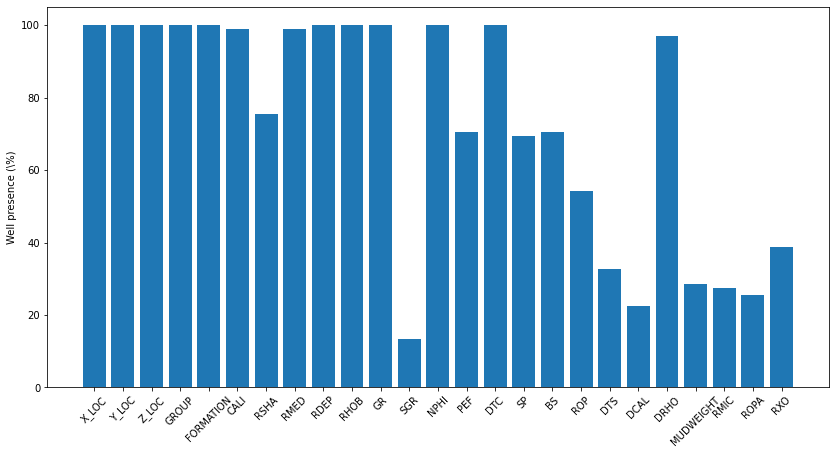

In [8]:
occurences = np.zeros(25)
for well in data['WELL'].unique():
    occurences += data[data['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(data.WELL.unique().shape[0]-occurences)/data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(data.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

## New visualization

### Ineractive visualization of missing logs

In [9]:
import ipywidgets as widgets
from ipywidgets import interactive, interact

In [10]:
wells = data['WELL'].unique()
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

Using the `@interact` decorator we can get a quick way to choose a single well and inspect its data on the fly by just ttyping the well name:

In [11]:
@interact
def data_well_view(WELL=''):
    return data[data['WELL']==WELL]

interactive(children=(Text(value='', description='WELL'), Output()), _dom_classes=('widget-interact',))

With `interactive` and a similar logic (`data['WELL'].unique()`) we can, on the other hand, check the selected well's curves completeness, again on the fly.

I am using the library `missingno` to make the visual summary plot.

As explained in the library's documentation, the sparkline at the right of the plot summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset. 

This to me is a much more compelling and informative way to inspect the data as it shows the data range where data is missing.

The plot height is proportional to the well length (in rows), which is also annotated on the bottom left.

In [12]:
well_items = data['WELL'].unique()

In [13]:
def plot_missingno(w):  
    msno.matrix(w, color=(0., 0., 0.45))   
    fig = plt.gcf()
    fig.set_size_inches(20, np.round(len(w)/750)) # plot heigth proportional to selected well's length (in rows)
    plt.show()
    
def data_missingno_view(WELL=''):
    return plot_missingno(data.loc[data['WELL']==WELL])

well_select = widgets.Select(options=well_items)
interactive(data_missingno_view, WELL=well_select)

interactive(children=(Select(description='WELL', options=('15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A…

### Ineractive well plotting based on plotting routine from the starter notebook

We can reuse the mechanism from above to interactively select a well to plot:

In [14]:
def plot_well(w):
    fig, axs = plt.subplots(1, len(w.columns)-9, sharey=True)
    fig.set_size_inches(20, np.round(len(w)/750))
    for ic, col in enumerate(set(w.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                         'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                        'X_LOC', 'Y_LOC', 'Z_LOC'])):
        axs[ic].plot(w[col], w['DEPTH_MD'])
        axs[ic].set_xlabel(col)
    axs[0].set_ylim(w['DEPTH_MD'].values[-1], w['DEPTH_MD'].values[0])
    plt.show()

In [15]:
def well_plot_view(WELL=''):
    return plot_well(data.loc[data['WELL']==WELL])

well_select = widgets.Select(options=well_items)
interactive(well_plot_view, WELL=well_select)

interactive(children=(Select(description='WELL', options=('15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A…

### Ineractive well plotting based on plotting routine from the Cegal notebook

To finish up, a very nice plot using the Well Plotter from the [Cegal Tools package](https://github.com/cegaltools/cegaltools) showcased [here](https://nbviewer.jupyter.org/urls/gitlab.com/hilde.tveit.haland/public-notebooks/-/raw/master/Force%202020-%20CegalWells%20EDA.ipynb):

In [16]:
from cegaltools.plotting import CegalWellPlotter as cwp

In [17]:
data['FORCE_2020_LITHOFACIES_CONFIDENCE'] = 1/data['FORCE_2020_LITHOFACIES_CONFIDENCE']

In [18]:
def plot_well_cegal(w):
    cwp.plot_logs(df=w.set_index('DEPTH_MD'),
                  logs=['GROUP','FORMATION', 'RHOB', 'GR', 'NPHI', 'DTC', 'DTS'], 
                  log_scale_logs=['RMED', 'RDEP'],
                  lithology_logs='FORCE_2020_LITHOFACIES_LITHOLOGY', 
                  lithology_proba_logs='FORCE_2020_LITHOFACIES_CONFIDENCE')

In [19]:
def well_plot_cegal_view(WELL=''):
    return plot_well_cegal(data.loc[data['WELL']==WELL])

well_select = widgets.Select(options=well_items)
interactive(well_plot_cegal_view, WELL=well_select)

interactive(children=(Select(description='WELL', options=('15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A…